In [1]:
from ROOT import TFile, TCanvas
from Scripts.DataFormat import Particle, get_leptons, get_jets
from Scripts.HistTools import HistTool
from ROOT import EnableImplicitMT
EnableImplicitMT(4)

Welcome to JupyROOT 6.24/00


In [2]:
f = TFile.Open("/Users/choij/workspace/HcToWA/Samples/Selector/2017/Skim1E2Mu__/Selector_SkimTree_SS2lOR3l_TTLL_powheg.root")
fr_ele = TFile.Open("/Users/choij/workspace/HcToWA/MetaInfo/2017/fakerate_electron.root")
fr_mu = TFile.Open("/Users/choij/workspace/HcToWA/MetaInfo/2017/fakerate_muon.root")

h_ele = fr_ele.Get("fakerate2D")
h_mu = fr_mu.Get("fakerate2D")

h_ele.SetDirectory(0)
h_mu.SetDirectory(0)

fr_ele.Close()
fr_mu.Close()

htool = HistTool(outfile="FRClosure_1E2Mu.root")

In [3]:
def get_tight_leptons(muons, electrons):
    muons_tight = []
    electrons_tight = []
    for muon in muons:
        if muon.IsTight():
            muons_tight.append(muon)
    for electron in electrons:
        if electron.IsTight():
            electrons_tight.append(electron)

    return muons_tight, electrons_tight

In [4]:
def get_fake_weight(muons, electrons):
    w_fake = -1.
    w_fake_up = -1.
    w_fake_down = -1.
    for muon in muons:
        ptCorr = muon.Pt()*(1.+max(muon.MiniIso()-0.1, 0.))
        ptCorr = min(ptCorr, 49.)
        absEta = abs(muon.Eta())
        this_bin = h_mu.FindBin(ptCorr, absEta)
        fr = h_mu.GetBinContent(this_bin)
        fr_up = fr + h_mu.GetBinError(this_bin)
        fr_down = fr - h_mu.GetBinError(this_bin)

        if muon.IsTight():
            continue
        else:
            w_fake *= -fr/(1.-fr)
            w_fake_up *= -fr_up/(1.-fr_up)
            w_fake_down *= -fr_down/(1.-fr_down)
    for ele in electrons:
        ptCorr = ele.Pt()*(1.+max(ele.MiniIso()-0.1, 0.))
        ptCorr = min(ptCorr, 49.)
        absEta = abs(ele.Eta())
        this_bin = h_ele.FindBin(ptCorr, absEta)
        fr = h_ele.GetBinContent(this_bin)
        fr_up = fr + h_ele.GetBinError(this_bin)
        fr_down = fr - h_ele.GetBinError(this_bin)

        if ele.IsTight():
            continue
        else:
            w_fake *= -fr/(1.-fr)
            w_fake_up *= -fr_up/(1.-fr_up)
            w_fake_down *= -fr_down/(1.-fr_down)

    return w_fake, w_fake_up, w_fake_down

In [5]:
def select(evt, muons, electrons):
    if not (evt.passDblMuTrigs or evt.passEMuTrigs):
        return False
    
    pass_safecut = ((muons[0].Pt() > 20. and muons[1].Pt() > 10.) or
                    (muons[0].Pt() > 25. and electrons[0].Pt() > 15.) or
                    (electrons[0].Pt() > 25. and muons[0].Pt() > 10.))

    if not pass_safecut:
        return False

    if not (len(muons) == 2 and len(electrons) == 1):
        return False
    
    return True

In [6]:
for evt in f.Events:
    muons, electrons = get_leptons(evt)
    
    if not select(evt, muons, electrons):
        continue

    # check if pass tight IDs
    muons_tight, electrons_tight = get_tight_leptons(muons, electrons)
    if len(muons_tight) == 2 and len(electrons_tight) == 1:
        n_prompt = 0
        n_fake = 0
        for lep in muons + electrons:
            if lep.LepType() < 0:
                n_fake += 1
            elif lep.LepType() in [1, 2, 6]:
                n_prompt += 1
            else:
                pass
    
        if (n_prompt == 2 and n_fake == 1):
            htool.fill_muons("prompt/muons", muons, 1.)
            htool.fill_electrons("prompt/electrons", electrons, 1.)
    else:
        w_fake, w_fake_up, w_fake_down = get_fake_weight(muons, electrons)
        htool.fill_muons("fake/Central/muons", muons, w_fake)
        htool.fill_muons("fake/Up/muons", muons, w_fake_up)
        htool.fill_muons("fake/Down/muons", muons, w_fake_down)
        htool.fill_electrons("fake/Central/electrons", electrons, w_fake)
        htool.fill_electrons("fake/Up/electrons", electrons, w_fake_up)
        htool.fill_electrons("fake/Down/electrons", electrons, w_fake_down)
htool.save()

Saving histograms in FRClosure_1E2Mu.root...


In [2]:
f = TFile("FRClosure_1E2Mu.root")
f.ls()

TFile**		FRClosure_1E2Mu.root	
 TFile*		FRClosure_1E2Mu.root	
  KEY: TDirectoryFile	fake;1	fake/Central/muons
  KEY: TDirectoryFile	prompt;1	prompt/muons


17676.0
18337.141879561532, 4126.947854112281, 3548.0243883839357


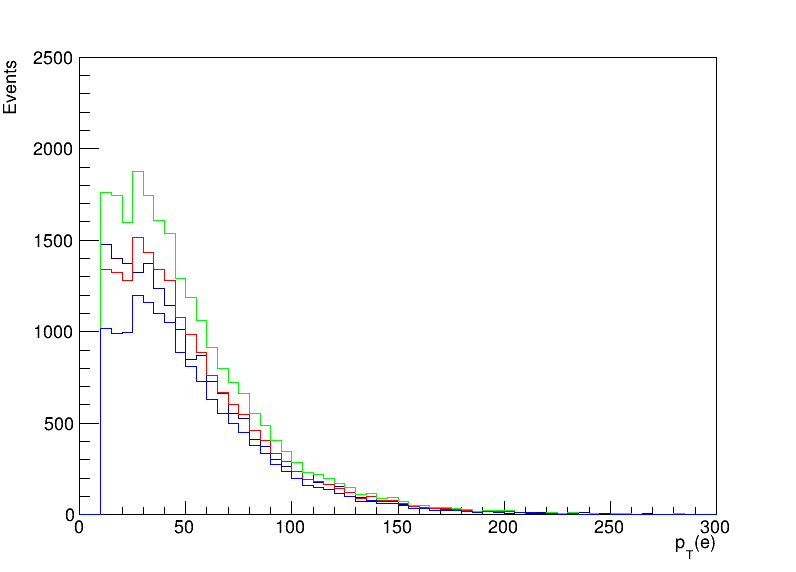

In [3]:
cvs = TCanvas("cvs", "", 800, 600)
cvs.cd()
h_prompt = f.Get("prompt/electrons/1/pt")
h_prompt.SetStats(0)
h_prompt.GetYaxis().SetRangeUser(0, 2500)
h_prompt.Rebin(5)
h_prompt.GetXaxis().SetTitle("p_{T}(e)")
h_prompt.GetYaxis().SetTitle("Events")
h_fake = f.Get("fake/Central/electrons/1/pt")
h_fake.SetStats(0)
h_fake.SetLineColor(2)
h_fake.Rebin(5)
h_fake_up = f.Get("fake/Up/electrons/1/pt")
h_fake_up.SetStats(0)
h_fake_up.SetLineColor(3)
h_fake_up.Rebin(5)
h_fake_down = f.Get("fake/Down/electrons/1/pt")
h_fake_down.SetStats(0)
h_fake_down.SetLineColor(4)
h_fake_down.Rebin(5)

h_prompt.Draw()
h_fake.Draw("same&hist")
h_fake_up.Draw("same&hist")
h_fake_down.Draw("same&hist")

cvs.Draw()

print(h_prompt.Integral())
print(f"{h_fake.Integral()}, {h_fake_up.Integral() - h_fake.Integral()}, {h_fake.Integral() - h_fake_down.Integral()}")